This is an implementation of Dice from this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10179900. Good paper but no source code, so here is some source code. The eventual goal is to build and train an embeddings model. 

First is the pre-processing. The paper does the following pre-processing steps:
- Butterworth band-pass filter with a frequency range of 0.5 to 45 Hz

In [7]:
import mne
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import einops
from scipy.signal import butter, filtfilt


# full_data = torch.tensor([mne.io.read_raw_eeglab(f'ds004504-download/sub-{"{:03}".format(i)}/eeg/sub-{"{:03}".format(i)}_task-eyesclosed_eeg.set', preload=True).get_data() for i in range(1, 89)])

diag = pd.read_csv('ds004504-download/participants.tsv', sep='\t')["Group"]
diags = []
all_data = []
samples_per_epoch = 500 * 30

for i, curr_diag in zip(list(range(1, 89)), diag):
    # apply butterworth to 0.5-45 Hz
    raw = mne.io.read_raw_eeglab(f'ds004504-download/sub-{"{:03}".format(i)}/eeg/sub-{"{:03}".format(i)}_task-eyesclosed_eeg.set', preload=True)    
    raw.filter(0.5, 45, method='iir', iir_params=dict(order=4, ftype='butter'), verbose=False)    
    data = np.asarray(raw.get_data()) # shape: 19, n_samples

    # chop up data into 30_000 sample epochs
    n_samples = data.shape[1]
    n_epochs = n_samples // samples_per_epoch
    data = data[:, :n_epochs*samples_per_epoch].reshape(19, n_epochs, samples_per_epoch)
    all_data.append(data)

    diags.extend([curr_diag]*n_epochs)

all_data = np.concatenate(all_data, axis=1)
all_data = einops.rearrange(all_data, 'channels epochs samples -> epochs channels samples')


In [2]:
# get number of bytes in all_data
print(all_data.nbytes / 1e9, "GB")

5.26224 GB


In [5]:
print(all_data.shape)

torch.Size([2308, 19, 15000])


In [50]:

import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Designs a Butterworth bandpass filter.

    Parameters:
    - lowcut: Lower cutoff frequency of the filter.
    - highcut: Upper cutoff frequency of the filter.
    - fs: Sampling frequency.
    - order: Order of the Butterworth filter.

    Returns:
    - b, a: Numerator (b) and denominator (a) polynomials of the filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def fft_filter(data, bands, fs, order=4):
    """
    Applies a Butterworth bandpass filter to the data for each specified frequency band.

    Parameters:
    - data: Input signal data (1D array).
    - bands: List of tuples specifying the frequency bands [(low1, high1), (low2, high2), ...].
    - fs: Sampling frequency.
    - order: Order of the Butterworth filter.

    Returns:
    - A 2D array where each row corresponds to the filtered signal for each band.
    """
    ret = []

    for low, high in bands:
        # Design the Butterworth bandpass filter for the given band
        b, a = butter_bandpass(low, high, fs, order=order)
        # Apply the filter to the data
        filtered_signal = filtfilt(b, a, data)
        ret.append(filtered_signal)

    # Stack the filtered signals along the first axis
    return np.stack(ret, axis=0)

dat = []

for idx, data in enumerate(all_data):
    # apply bandpass filter
    # Delta: 0.5 – 4 Hz
    # Theta: 4 – 8 Hz
    # Alpha: 8 – 13 Hz
    # Beta: 13-25 Hz
    # Gamma: 25-45 Hz

    bands = [(0.5, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    filtered = fft_filter(data, bands, fs=500) # 5, 19, 15000 (bands, channels, samples)

    # break it into one second epochs (time, bands, channels, sampels), with 30 such epochs
    n_epochs = samples_per_epoch // 500
    filtered = filtered.reshape(5, 19, n_epochs, 500)
    filtered = np.moveaxis(filtered, 2, 0)

    print(filtered.shape)

    # for each timestep, get the relative power of each band
    total_power = np.sum(filtered**2, axis=1)
    print(total_power.shape)
    relative_power = filtered / total_power[:, None, :, :]
    relative_power = np.mean(relative_power, axis=3)
    print(relative_power.shape)
    plt.imshow(relative_power[0])
    plt.colorbar()
    plt.show()

    print(np.max(relative_power))


    print(filtered.shape)
    



    break



Filtered shape: (30, 5, 19, 500)
Filtered data range: min = -0.0001359536134830098 max = 0.00022224395752454236
Total power shape: (30, 19, 500)
Max total power: 0.00024467752188748684
Min total power: -0.00014248668672956562
Relative power shape: (30, 5, 19)
Max relative power: 3475.346225160363
Min relative power: -322491.8365954288


In [39]:
print(all_data.shape) # num_channels, num_epochs, num_samples

torch.Size([1132, 19, 30000])


## We can take a before and after this first processing step

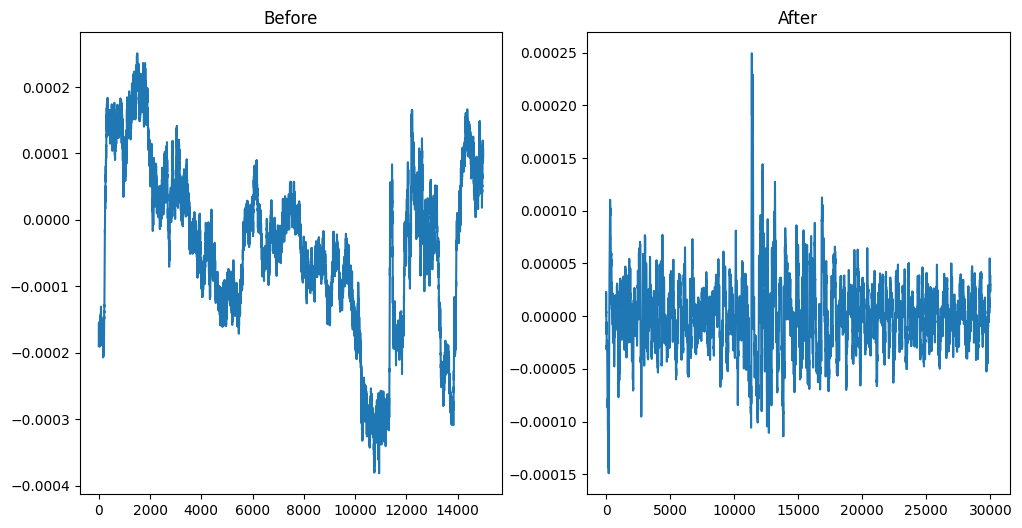

In [36]:
# Load the raw EEG data
display(Markdown("## We can take a before and after this first processing step"))

raw = mne.io.read_raw_eeglab('ds004504-download/sub-001/eeg/sub-001_task-eyesclosed_eeg.set', preload=True)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the 'Before' data on the first subplot
axs[0].plot(raw.get_data()[0][:15_000])
axs[0].set_title('Before')

# Plot the 'After' data on the second subplot
axs[1].plot(all_data[0, 0])
axs[1].set_title('After')

# Show the plots
plt.show()

